# Installation

In [1]:
!pip install torchsummary

# Imports

In [2]:
# Standard library imports
import os
import time
import copy
from collections import defaultdict

# Data handling and visualization
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# PyTorch imports for neural network architecture and data handling
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchsummary import summary

# torchvision for datasets and image transformations
from torchvision import datasets, models, transforms

# Kornia for image augmentations
import kornia.augmentation as K
from kornia.augmentation import AugmentationSequential

# Scikit-learn for evaluation metrics
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

# Enable inline plotting for Jupyter notebooks
%matplotlib inline

# Dataset

## Helper functions

In [3]:
def get_classes_names(data_path):
    classes_names = [d for d in os.listdir(data_path) if os.path.isdir(os.path.join(data_path, d))]
    return classes_names

# Function to apply the transformations on the datasets 
def load_and_transform_datasets(data_path):
    data_transforms = {
        'train': transforms.Compose([
            transforms.RandomResizedCrop(98),
            transforms.ToTensor(),
            transforms.Normalize([0.482, 0.468, 0.419], [0.209, 0.206, 0.221])
        ]),

        'val': transforms.Compose([
            transforms.Resize(100),
            transforms.CenterCrop(98),
            transforms.ToTensor(),
            transforms.Normalize([0.482, 0.468, 0.419], [0.209, 0.206, 0.221])
        ]),

        'test': transforms.Compose([
            transforms.Resize(100),
            transforms.CenterCrop(98),
            transforms.ToTensor(),
            transforms.Normalize([0.482, 0.468, 0.419], [0.209, 0.206, 0.221])
        ])
    }
    
    image_datasets = {
        'train': datasets.ImageFolder(root=os.path.join(data_path, 'train'), transform=data_transforms['train']),
        'val': datasets.ImageFolder(root=os.path.join(data_path, 'val'), transform=data_transforms['val']),
        'test': datasets.ImageFolder(root=os.path.join(data_path, 'test'), transform=data_transforms['test'])
    }
    
    return image_datasets

def show_images(dataloader, num_images=6):
    # Prepare the figure
    fig, axes = plt.subplots(1, num_images, figsize=(15, 5))
    axes = axes.flatten()
    
    classes_names = dataloader.dataset.classes
    data_mean = np.array([0.482, 0.468, 0.419]) 
    data_std = np.array([0.209, 0.206, 0.221])

    dataloader_iter = iter(dataloader)
    
    # Fetch a batch of images and labels
    images, labels = next(dataloader_iter)
    
    for i in range(num_images):
        # Convert tensor image to numpy array
        image = images[i].numpy().transpose(1, 2, 0)  # Change shape from CxHxW to HxWxC
        
        # Denormalize the image
        image = image * data_std + data_mean
        image = np.clip(image, 0, 1)
        
        label = labels[i].item()
        
        axes[i].imshow(image)
        axes[i].set_title(classes_names[label])
        axes[i].axis('off')

    plt.tight_layout()
    plt.show()
    
# Function to summarizes the dataset structure and class distribution without loading actual data.
def summarize_datasets(data_path):
    # Initialize class counts for each dataset
    class_counts = {
        'train': defaultdict(int),
        'val': defaultdict(int),
        'test': defaultdict(int)
    }
    
    # Define directory names
    split_dirs = ['train', 'val', 'test']
    
    # Get the list of class names (assuming each subfolder in train, val, and test folders is a class)
    all_classes = set()
    for split in split_dirs:
        split_dir = os.path.join(data_path, split)
        if os.path.isdir(split_dir):
            classes_names = os.listdir(split_dir)
            all_classes.update(classes_names)
            for class_name in classes_names:
                class_counts[split][class_name] = len(os.listdir(os.path.join(split_dir, class_name)))

    # Prepare the table data for visualization
    table_data = []

    # Create the header row for the table
    header_row = ["Class"] + ['Train', 'Validation', 'Test', 'Total']
    table_data.append(header_row)

    # Add data rows for each class
    for class_name in sorted(all_classes):
        train_count = class_counts['train'].get(class_name, 0)
        val_count = class_counts['val'].get(class_name, 0)
        test_count = class_counts['test'].get(class_name, 0)
        total_count = train_count + val_count + test_count
        row = [class_name, train_count, val_count, test_count, total_count]
        table_data.append(row)

    # Add the last row with totals
    total_train = sum(class_counts['train'].values())
    total_val = sum(class_counts['val'].values())
    total_test = sum(class_counts['test'].values())
    overall_total = total_train + total_val + total_test
    total_row = ["Total", total_train, total_val, total_test, overall_total]
    table_data.append(total_row)

    # Create a DataFrame for better visualization
    df = pd.DataFrame(table_data[1:], columns=table_data[0])

    # Apply alignment styles and borders for the DataFrame
    styles = [
        {'selector': 'th', 'props': [('text-align', 'center'), ('border', '1px solid black')]}, 
        {'selector': 'td', 'props': [('text-align', 'center'), ('border', '1px solid black')]}, 
    ]

    styled_df = df.style.set_table_styles(styles)

    return styled_df

In [4]:
# Define a list of data augmentations using Kornia
aug_list = AugmentationSequential(
    K.ColorJitter(brightness=0.1, contrast=0.1, saturation=0.1, hue=0.05, p=0.3),
    K.RandomAffine(degrees=15, translate=(0.05, 0.05), scale=(0.9, 1.1), p=0.5),
    K.RandomHorizontalFlip(p=0.5),
    same_on_batch=False,
)

## Visualization

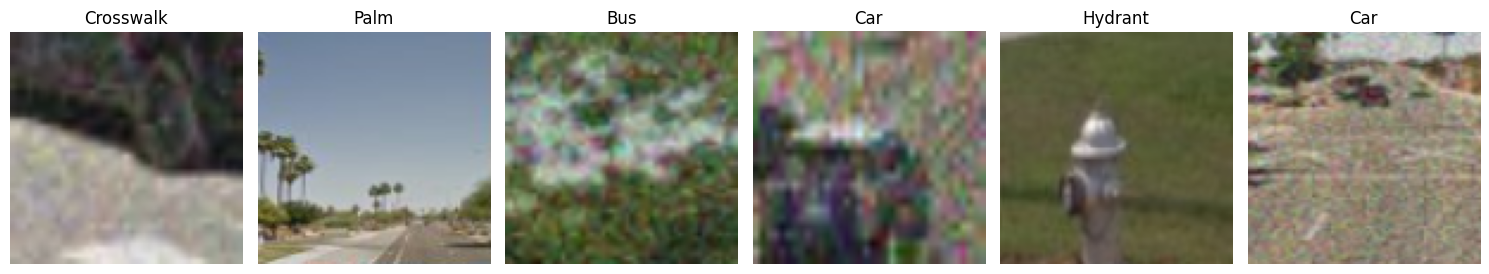

In [5]:
data_path = '../dataset'

image_datasets = load_and_transform_datasets(data_path)

train_dataloader = DataLoader(image_datasets['train'], batch_size=128, num_workers=2, shuffle=True)
show_images(train_dataloader, num_images=6)

In [6]:
summarized_table = summarize_datasets(data_path)
display(summarized_table)

,Class,Train,Validation,Test,Total
0,Bicycle,1705,365,366,2436
1,Bridge,1267,271,273,1811
2,Bus,5862,1256,1257,8375
3,Car,6776,1452,1453,9681
4,Chimney,272,58,59,389
5,Crosswalk,2307,494,495,3296
6,Hydrant,4872,1044,1045,6961
7,Motorcycle,193,41,43,277
8,Palm,1791,383,385,2559
9,Stair,450,96,98,644


# Device

In [7]:
# Device configuration:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

print(device)

cuda:0


# Define a DoRA low-rank layer

In [8]:
# Define a custom PyTorch module for a DoRA low-rank layer
class LowRankLayer(nn.Module):
    def __init__(self, linear, rank, alpha):
        super().__init__()
        """
        Custom PyTorch module for a dora low-rank layer.

        Args:
            linear (nn.Linear): Linear layer to be adapted.
            rank (int): Controls the inner dimension of the matrices A and B.
            alpha (float): Scaling hyper-parameter applied to the output of the low-rank adaptation.
        """
        self.rank = rank
        self.alpha = alpha
        self.linear = linear
        self.in_dim = linear.in_features
        self.out_dim = linear.out_features

        # weights
        std_dev = 1 / torch.sqrt(torch.tensor(self.rank).float())
        self.A = nn.Parameter(torch.randn(self.in_dim, self.rank) * std_dev)
        self.B = nn.Parameter(torch.zeros(self.rank, self.out_dim))
        self.m = nn.Parameter(self.linear.weight.norm(p=2, dim=0, keepdim=True))

    def forward(self, x):
        lora = self.A @ self.B  # combine LoRA matrices
        numerator = self.linear.weight + self.alpha * lora.T
        denominator = numerator.norm(p=2, dim=0, keepdim=True)
        directional_component = numerator / denominator
        new_weight = self.m * directional_component
        return F.linear(x, new_weight, self.linear.bias)

# Helper functions

In [9]:
def train_and_val_model(model, dataloaders, criterion, optimizer, num_epochs):
    since = time.time()

    val_acc_history = []
    train_acc_history = []

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(1, num_epochs+1):
        print('Epoch {}/{}'.format(epoch, num_epochs))
        print('-' * 10)
        
        epoch_start = time.time()

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)
                
                if phase == 'train':
                    inputs = aug_list(inputs)  # Augmentation

                # Forward pass
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # Backward + optimize in the training phase
                    if phase == 'train':
                        optimizer.zero_grad()
                        loss.backward()
                        optimizer.step()

                # Statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)

            # Move epoch_acc to CPU and convert to float for compatibility
            epoch_acc = epoch_acc.cpu().item()

            print('{} Loss: {:.4f}, Accuracy: {:.2f}%'.format(phase, epoch_loss, epoch_acc * 100))

            # Save the accuracy history
            if phase == 'train':
                train_acc_history.append(epoch_acc)
            else:
                val_acc_history.append(epoch_acc)

            # Deep copy the model if it's the best accuracy
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())
        
        epoch_time_elapsed = time.time() - epoch_start
        print('Epoch Time: {:.0f}m {:.0f}s'.format(epoch_time_elapsed // 60, epoch_time_elapsed % 60))
        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best Validation Accuracy: {:.2f}%'.format(best_acc * 100))

    # Load the best model weights
    model.load_state_dict(best_model_wts)
    return model, train_acc_history, val_acc_history

# Function for testing the model
def test_model(model, dataloaders):
    model.eval()
    
    total_correct = 0
    total_images = 0
    test_predicted = []
    test_labels = []

    with torch.no_grad():
        for data in dataloaders['test']:
            images, labels = data
            images = images.to(device)
            labels = labels.to(device)
            
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            
            total_images += labels.size(0)
            total_correct += (predicted == labels).sum().item()
            
            test_labels += (labels.cpu().numpy().tolist())
            test_predicted += (predicted.cpu().numpy().tolist())

    model_accuracy = total_correct / total_images
    print(f"Model accuarcy is: {100*model_accuracy:.2f}%")
    
    return test_labels, test_predicted

# Function to show the confusion matrix
def show_confusion_matrix(df_cm, title='Confusion Matrix'):
    plt.figure(figsize=(10, 7))
    sns.heatmap(df_cm, annot=True, fmt='g', cmap='Blues', cbar=False)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title(title)
    plt.show()
    


# Initialize Custom Resnet18 Classifier

In [10]:
# Dataset classes 
classes_names = get_classes_names(data_path+'/train')
num_classes = len(classes_names)

# Fine-tuning parameters 
weights = 'DEFAULT'
rank = 4
alpha = 8

# Initialize the model
model = models.resnet18(weights=weights)
model.requires_grad_(False)
num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, num_classes)
model.fc = LowRankLayer(model.fc, rank, alpha)
input_size = 98

# Move model to device
model = model.to(device)

print(model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [11]:
# Dimensions, Parameters and Size
summary(model, (3, 98, 98))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 49, 49]           9,408
       BatchNorm2d-2           [-1, 64, 49, 49]             128
              ReLU-3           [-1, 64, 49, 49]               0
         MaxPool2d-4           [-1, 64, 25, 25]               0
            Conv2d-5           [-1, 64, 25, 25]          36,864
       BatchNorm2d-6           [-1, 64, 25, 25]             128
              ReLU-7           [-1, 64, 25, 25]               0
            Conv2d-8           [-1, 64, 25, 25]          36,864
       BatchNorm2d-9           [-1, 64, 25, 25]             128
             ReLU-10           [-1, 64, 25, 25]               0
       BasicBlock-11           [-1, 64, 25, 25]               0
           Conv2d-12           [-1, 64, 25, 25]          36,864
      BatchNorm2d-13           [-1, 64, 25, 25]             128
             ReLU-14           [-1, 64,

In [12]:
# Print and collect learnable parameters
params_to_update = model.parameters()
print("Params to learn:")
for name, param in model.named_parameters():
    if param.requires_grad:
        print("\t", name)
        
# Define optimizer
optimizer = torch.optim.Adam(params_to_update, lr=0.0002)

# Define loss criterion
criterion = nn.CrossEntropyLoss()

# Batch size for training
batch_size = 256

# Number of epochs to train for
num_epochs = 25

# Prepare the dataloaders
dataloaders = {
    'train': DataLoader(image_datasets['train'], batch_size=batch_size, shuffle=True, num_workers=2),
    'val': DataLoader(image_datasets['val'], batch_size=batch_size, shuffle=False, num_workers=2),
    'test': DataLoader(image_datasets['test'], batch_size=batch_size, shuffle=False, num_workers=2)
}

Params to learn:
	 fc.A
	 fc.B
	 fc.m
	 fc.linear.weight
	 fc.linear.bias


# Train

In [13]:
# Train, Validate and evaluate the model
model, train_accuracies, val_accuracies = train_and_val_model(model, dataloaders, criterion, optimizer, num_epochs)

Epoch 1/25
----------
train Loss: 1.8589, Accuracy: 37.28%
val Loss: 1.4402, Accuracy: 53.28%
Epoch Time: 0m 37s

Epoch 2/25
----------
train Loss: 1.5169, Accuracy: 50.45%
val Loss: 1.1459, Accuracy: 63.02%
Epoch Time: 0m 38s

Epoch 3/25
----------
train Loss: 1.3542, Accuracy: 56.22%
val Loss: 0.9840, Accuracy: 68.96%
Epoch Time: 0m 38s

Epoch 4/25
----------
train Loss: 1.2687, Accuracy: 59.09%
val Loss: 0.9110, Accuracy: 71.16%
Epoch Time: 0m 37s

Epoch 5/25
----------
train Loss: 1.2098, Accuracy: 60.72%
val Loss: 0.8536, Accuracy: 72.62%
Epoch Time: 0m 38s

Epoch 6/25
----------
train Loss: 1.1716, Accuracy: 62.06%
val Loss: 0.8179, Accuracy: 73.94%
Epoch Time: 0m 37s

Epoch 7/25
----------
train Loss: 1.1474, Accuracy: 62.50%
val Loss: 0.8026, Accuracy: 74.29%
Epoch Time: 0m 38s

Epoch 8/25
----------
train Loss: 1.1296, Accuracy: 63.07%
val Loss: 0.7681, Accuracy: 75.64%
Epoch Time: 0m 38s

Epoch 9/25
----------
train Loss: 1.1105, Accuracy: 63.43%
val Loss: 0.7700, Accuracy: 7

In [14]:
import csv

# Export the accuracy histories to a CSV file
with open('resnet_accuracy_history.csv', 'w', newline='') as file:
    writer = csv.writer(file)
    writer.writerow(['Epoch', 'Train Accuracy', 'Validation Accuracy'])

    for epoch in range(len(train_accuracies)):
        writer.writerow([epoch + 1, train_accuracies[epoch], val_accuracies[epoch]])

print("Accuracy histories exported to 'resnet_accuracy_history.csv'")

Accuracy histories exported to 'resnet_accuracy_history.csv'


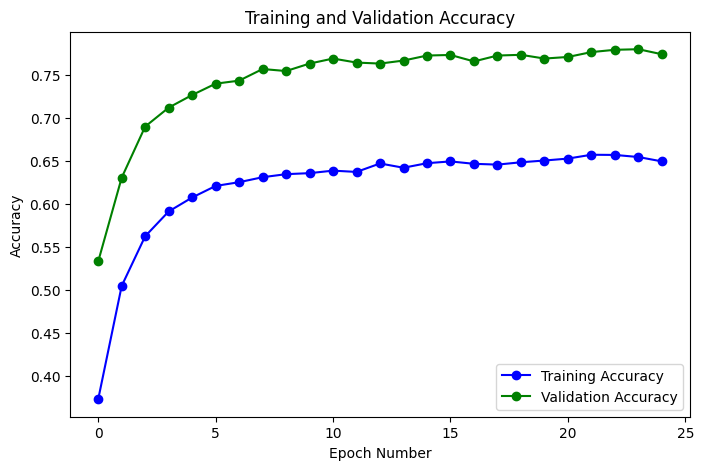

In [15]:
# Plotting train and validation accuracy vs epoch
plt.figure(figsize=(8, 5))

plt.plot(train_accuracies, label='Training Accuracy', color='blue', linestyle='-', marker='o')
plt.plot(val_accuracies, label='Validation Accuracy', color='green', linestyle='-', marker='o')

plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch Number")
plt.ylabel("Accuracy")
plt.legend()

plt.show()

# Test

In [16]:
test_labels, test_predicted = test_model(model, dataloaders)

Model accuarcy is: 77.80%


In [17]:
# Display the classification report
print(classification_report(test_labels, test_predicted, target_names=classes_names))

               precision    recall  f1-score   support

   Motorcycle       0.83      0.72      0.77       366
      Hydrant       0.79      0.62      0.69       273
          Bus       0.79      0.87      0.83      1257
          Car       0.68      0.78      0.72      1453
    Crosswalk       0.78      0.64      0.70        59
        Stair       0.83      0.65      0.73       495
Traffic Light       0.97      0.95      0.96      1045
       Bridge       0.47      0.21      0.29        43
      Bicycle       0.74      0.63      0.68       385
         Palm       0.61      0.50      0.55        98
      Chimney       0.68      0.69      0.69       540

     accuracy                           0.78      6014
    macro avg       0.74      0.66      0.69      6014
 weighted avg       0.78      0.78      0.78      6014



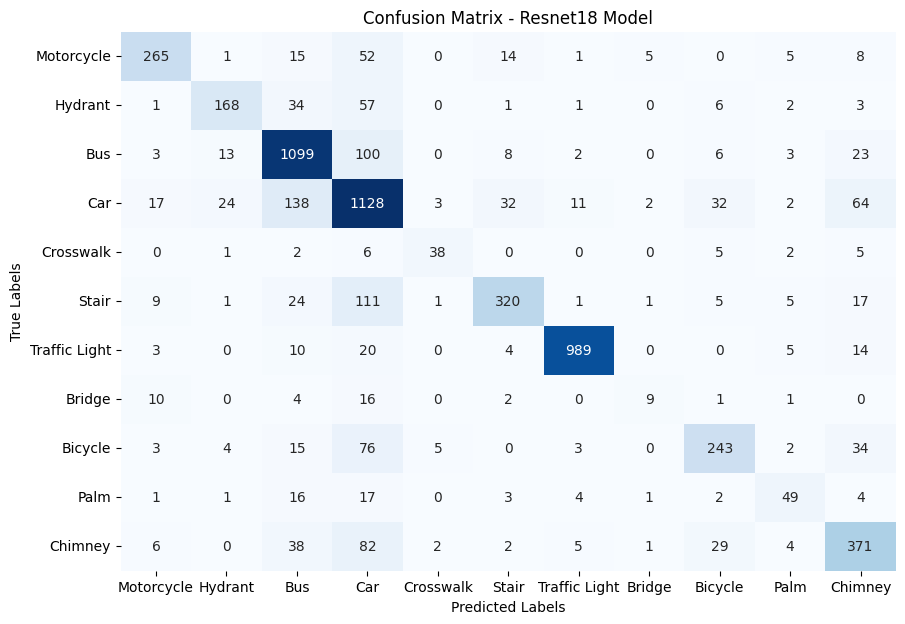

In [18]:
# Display the confusion matrix
cm = confusion_matrix(test_labels, test_predicted)
df_cm = pd.DataFrame(cm, index=classes_names, columns=classes_names)
show_confusion_matrix(df_cm, title='Confusion Matrix - Resnet18 Model')